In [1]:
import os
import sys
from dotenv import load_dotenv

sys.path.append('..')
load_dotenv()

import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer

/home/silvan/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
text_models = {
    "gte": "Alibaba-NLP/gte-large-en-v1.5",
    "mpnet": "all-mpnet-base-v2",
    "bge": "bge-base-en-1.5",
    "mxbai": "mixedbread-ai/mxbai-embed-large-v1"
}

text_model_key = "gte"
text_model = text_models[text_model_key]

In [4]:
encoder = SentenceTransformer(text_model, trust_remote_code=True, device=device)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.3.1+cu121)
    Python  3.10.11 (you have 3.10.9)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Encode and save sentences

In [5]:
# Load sentences from file
sentences_file = os.path.join("..", "sentences.json")

with open(sentences_file, "r") as f:
    sentences = json.load(f)

data = []
for category, types in sentences.items():
    for type_name, type_sentences in types.items():
        data.extend(type_sentences)

In [6]:
# Encode the sentences
embeddings = encoder.encode(data, convert_to_tensor=True).cpu().numpy()
print("Embeddings shape:", embeddings.shape)

# Create a dictionary with the sentence embeddings
sentence_embeddings = {}
for i in range(len(data)):
    sentence_embeddings[data[i]] = embeddings[i]

embeddings_file = os.path.join("..", "embeddings", f"sentence_embeddings_{text_model_key}.npz")

np.savez_compressed(embeddings_file, **sentence_embeddings)
print("Embeddings saved to:", embeddings_file)

Embeddings shape: (2695, 1024)
Embeddings saved to: ../embeddings/sentence_embeddings_gte.npz


### Plot T-SNE

In [7]:
sentence_embeddings_norm = {}

for sentence, embedding in sentence_embeddings.items():
    sentence_embeddings_norm[sentence] = embedding / np.linalg.norm(embedding)

structured_embeddings_flatten = {}
for category, types in sentences.items():
    for type_name, type_sentences in types.items():
        structured_embeddings_flatten[f"{category}/{type_name}"] = [sentence_embeddings_norm[sentence] for sentence in sentences[category][type_name]]

/tmp/ipykernel_26270/2811558348.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))


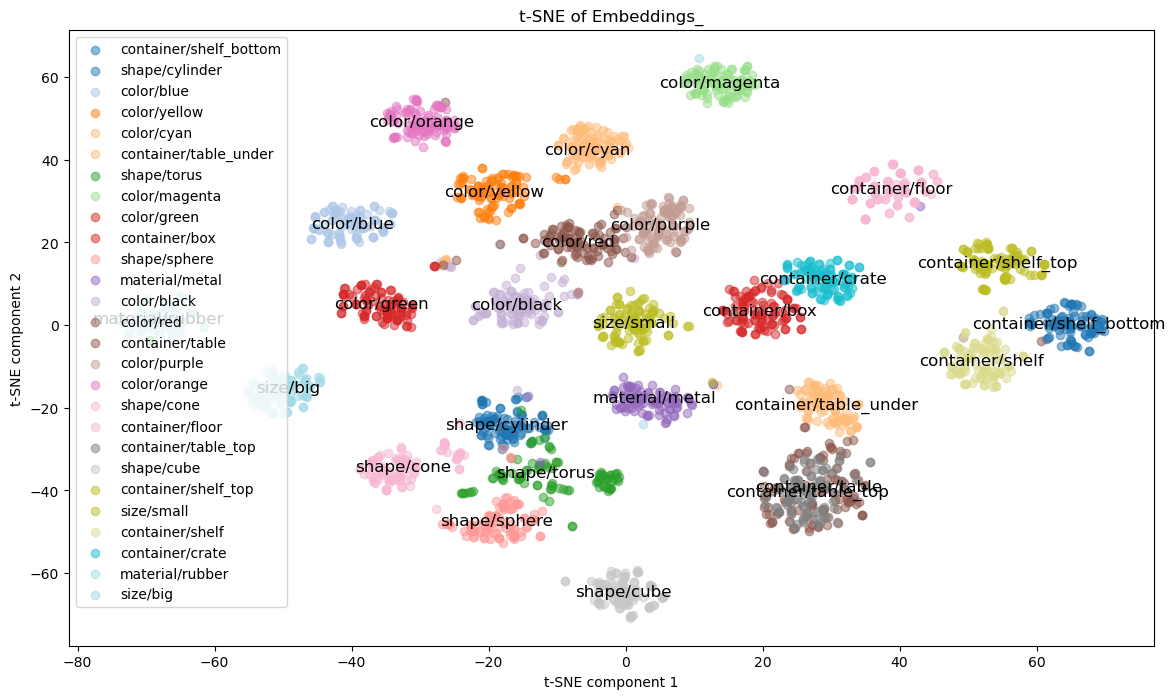

In [8]:
embeddings_ = []
labels_ = []

for label, emb_list in structured_embeddings_flatten.items():
    embeddings_.extend(emb_list)
    labels_.extend([label] * len(emb_list))

# Convert to numpy array
embeddings_ = np.array(embeddings_)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings_)

# Plotting
plt.figure(figsize=(14, 8))
unique_labels = list(set(labels_))
colors = plt.cm.get_cmap('tab20', len(unique_labels))

label_centers = {}

for i, label in enumerate(unique_labels):
    indices = [j for j, x in enumerate(labels_) if x == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[colors(i)], label=label, alpha=0.5)
    label_centers[label] = np.mean(tsne_results[indices], axis=0)

for label, center in label_centers.items():
    plt.text(center[0], center[1], label, fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Embeddings_")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

In [1]:
embeddings_

NameError: name 'embeddings_' is not defined